In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date, time, datetime

In [2]:
train_users = pd.read_csv("proj3_data/train_users.csv",parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
test_users = pd.read_csv("proj3_data/test_users.csv",parse_dates=['timestamp_first_active','date_account_created','date_first_booking'])
sessions = pd.read_csv("proj3_data/sessions.csv")

In [3]:
Y = train_users['country_destination'] # these are our labels
train_users = train_users.drop('country_destination', axis =1)

In [4]:
train_users.columns # exploratory 

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser'],
      dtype='object')

In [5]:
df_all = pd.concat((train_users, test_users), axis = 0, ignore_index= True)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Splitting date time data for date account created
df_all['dac_year'] = df_all.date_account_created.dt.year
df_all['dac_month'] = df_all.date_account_created.dt.month
df_all['dac_day'] = df_all.date_account_created.dt.day

# Splitting date time data for time first active
df_all['tfa_year'] = df_all.timestamp_first_active.dt.year
df_all['tfa_month'] = df_all.timestamp_first_active.dt.month
df_all['tfa_day'] = df_all.timestamp_first_active.dt.day

df_all.drop('date_account_created',1, inplace=True)
df_all.drop('timestamp_first_active',1, inplace=True)



In [7]:

#df_all.loc[df_all.age > 100, 'age'] = np.nan
#df_all.loc[df_all.age < 18, 'age'] = np.nan

age_values = df_all.age.values
df_all['age'] = np.where(age_values>1000, np.random.randint(28, 43), age_values)
df_all['age'] = df_all['age'].fillna(np.random.randint(28, 43))



In [8]:
by_signup_device = df_all.groupby(['signup_method', 'first_device_type'])
def impute_median(series):
    return series.fillna(series.median())
df_all.age = by_signup_device['age'].transform(impute_median)

In [9]:
tracked = []

for i in df_all['first_affiliate_tracked']:
    if i == "untracked" or i == "":
        isTracked = 0
    else:
        isTracked = 1
    tracked.append(isTracked)

df_all['is_first_affiliate_tracked'] = tracked

In [10]:
#seconds = sessions.groupby('id', as_index=False).agg({"secs_elapsed": "sum"})
#seconds.head()
#df_all = pd.merge(df_all, seconds, on="id", how="left")
#df_all['secs_elapsed'] = df_all['secs_elapsed'].fillna(0)

In [11]:
method = pd.get_dummies(df_all[["signup_method"]])
affch = pd.get_dummies(df_all[["affiliate_channel"]])
affprov = pd.get_dummies(df_all[["affiliate_provider"]])
firstdevice = pd.get_dummies(df_all[["first_device_type"]])
signupFlow = pd.get_dummies(df_all[["signup_flow"]].astype(str))
signup = pd.get_dummies(df_all[["signup_app"]])
genderdum = pd.get_dummies(df_all[["gender"]])
langdum = pd.get_dummies(df_all[["language"]])
browser = pd.get_dummies(df_all[["first_browser"]])

df2 = df_all

df2 = pd.concat([df2.reset_index(drop=True),method.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),affch.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),affprov.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),firstdevice.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),signupFlow.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),genderdum.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),signup.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),langdum.reset_index(drop=True)], axis=1)
df2 = pd.concat([df2.reset_index(drop=True),browser.reset_index(drop=True)], axis=1)

In [12]:
df2 = df2.drop(['id',  'date_first_booking','gender', 
          'signup_method',  'affiliate_channel', 'affiliate_provider', 'first_device_type', 
          'first_browser', 'signup_app', 'first_browser'], axis=1)



In [13]:
df2 = df2.drop("language", axis=1)

In [14]:
df2 = df2.drop('signup_flow', axis=1)
df2 = df2.drop(['first_affiliate_tracked'], axis=1)

In [15]:
id_test = test_users['id']

In [16]:
from sklearn.preprocessing import LabelEncoder

train_users_n = train_users.shape[0]
X_train = df2.values[:train_users_n]
le = LabelEncoder()
y_train = le.fit_transform(Y)   
X_test = df2.values[train_users_n:]


def generate_answer(y_pred, classifer_name):
    #Taking the 5 classes with highest probabilities
    ids = []  #list of ids
    cts = []  #list of countries
    for i in range(len(id_test)):
        idx = id_test[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()
    
    sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
    sub.to_csv(classifer_name+'.csv',index=False)
    return sub

In [20]:
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict_proba(X_test)


In [ ]:
generate_answer(y_pred_xgb, 'XGB')

AxesSubplot(0.125,0.125;0.775x0.755)


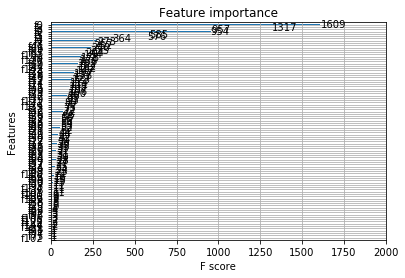

In [24]:
from xgboost import plot_importance
from matplotlib import pyplot
#plot_importance(age)
#pyplot.shot()

y = plot_importance(xgb, xlim=(0,2000))
print(y)
#y = model.get
pyplot.show()

In [25]:
print(xgb.feature_importances_)

[0.05191058 0.01919409 0.00507636 0.00420378 0.01308238 0.00627476
 0.00426548 0.00825259 0.03306636 0.04722851 0.00483957 0.
 0.00623991 0.05764911 0.00544218 0.00895577 0.00579471 0.00507735
 0.01249013 0.00580469 0.         0.00281321 0.00807086 0.
 0.01364122 0.00463779 0.00622658 0.00617511 0.00498917 0.00692823
 0.01620088 0.         0.00587757 0.00527203 0.00677081 0.
 0.00464705 0.         0.00762251 0.00335445 0.00411343 0.01147085
 0.02904201 0.         0.00635006 0.00466649 0.0083578  0.01446363
 0.04114122 0.         0.00746338 0.         0.         0.
 0.00687618 0.         0.00568009 0.00531469 0.00621126 0.00655062
 0.01646137 0.         0.0071928  0.0028411  0.00612623 0.05798159
 0.01790306 0.02242234 0.00466622 0.00563087 0.01090643 0.01796728
 0.00840865 0.         0.         0.00188086 0.         0.00641352
 0.00557824 0.00950938 0.00528461 0.         0.00672552 0.
 0.         0.         0.         0.00887426 0.00434279 0.00726563
 0.00426293 0.00971121 0.00551525 0